In [1]:
# -*- coding: utf-8 -*-

<br>
       ISS LIS Lightning Flash Heat Map and Flash Location <br>
       CSV File<br>
<br>
       Decription: This code pulls ISS LIS NetCDF data files <br>
       from a directory, extracts the flash coordinates from <br>
       the files and generates a flash heat map plot. This code <br>
       also compiles all lightning flash locations into a single <br>
       CSV file, so they may be plotted using other software<br>
<br>
       Authors: Amanda Markert and Essence Raphael<br>
       Information and Technology Systems Center (ITSC)<br>
       University of Alabama in Huntsville<br>
       <br>
       Last Edit Date: 02 August 2019<br>
<br>

 Import Python packages

['test_files/iss_lis/ISS_LIS_SC_V2.1_20220809_205914_NQC.nc', 'test_files/iss_lis/ISS_LIS_SC_V2.1_20220809_223204_NQC.nc']


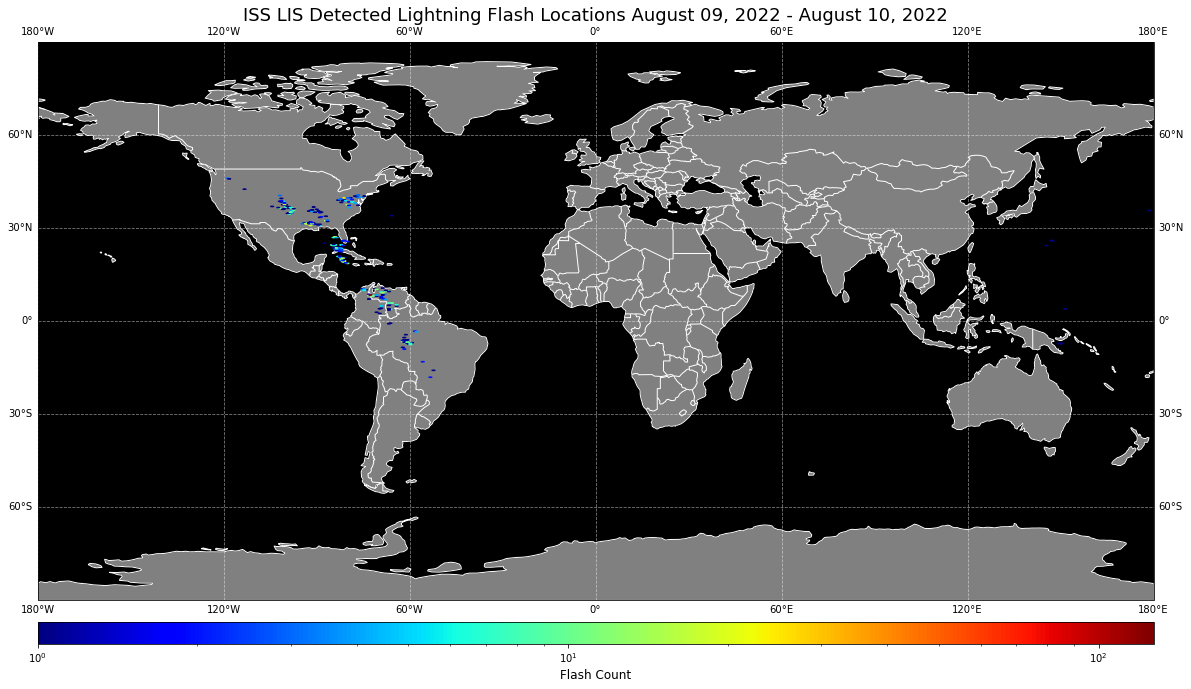

In [2]:
! pip install netCDF4
! pip install numpy
! pip install matplotlib
! pip install cartopy

# GEOS must be installed before exicution !

import sys
import os
import glob
from netCDF4 import Dataset, num2date
import numpy as np
import csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Initial file path. It can be changed by passing a different path as an argument
# to the main() function


def main(file_path):
    file_path = 'test_files/iss_lis/'
    #Define the directory of the files
    dataDir = os.path.join(file_path, '') 
    
    #Identify all the ISS LIS NetCDF files in the directory and their paths
    raw_files = glob.glob(dataDir+'ISS_LIS_*.nc')
    print(raw_files)
    files = [os.path.normpath(i) for i in raw_files]    
    
    #Extract the dates for the files
    #Create empty lists to hold the orbit start and end times
    orbit_start = []
    orbit_end = []
    
    #Loop through the NetCDF files and for each file, extract the start and end time of the ISS LIS
    #orbit, adding them to the respective empty list (orbit_start and orbit_end)
    for i in files:
        datafile = Dataset(i,'r')
    
        start_value = datafile.variables['orbit_summary_TAI93_start'][:].data.tolist()
        start_value_units = datafile.variables['orbit_summary_TAI93_start']
        end_value = datafile.variables['orbit_summary_TAI93_end'][:].data.tolist()
        end_value_units = datafile.variables['orbit_summary_TAI93_end']
        orbit_start.append(start_value)
        orbit_end.append(end_value)

    #From the start and end times, calculate the minimum and maximum date of the files
    start_dates = num2date(orbit_start[:], units=start_value_units.units)
    stop_dates = num2date(orbit_end[:], units=end_value_units.units)
    begin_date_value = min(start_dates)
    end_date_value = max(stop_dates)

    #Create text and numerical dates to use in file names and plot title
    begin_date = begin_date_value.strftime("%B %d, %Y")
    end_date = end_date_value.strftime("%B %d, %Y")
    begin_int = begin_date_value.strftime("%Y%m%d")
    end_int = end_date_value.strftime("%Y%m%d")
    
    #Create CSV file and destination
    csvfile = os.path.join(dataDir, 'isslis_flashloc_'+ begin_int + '_' + end_int +'.csv')
      
    #Extract lightning flash locations
    #Create empty arrays to populate lightning flash location coordinates 
    flash_lat = np.array([]) #latitude
    flash_lon = np.array([]) #longitude

    #Loop through list of NetCDF files and for each file, extract the lightning flash latidude
    #and longitude, adding them to the respective empty array (flash_lat and flash_lon)
    for i in files:
        datafile = Dataset(i)
    
        flash_lat = np.concatenate([flash_lat,datafile.variables['lightning_flash_lat'][:]]) #add to array
        flash_lon = np.concatenate([flash_lon,datafile.variables['lightning_flash_lon'][:]]) #add to array
    
    #Create CSV files of values from the populated flash_lat/lon arrays  
    with open(csvfile, 'w', newline='') as myfile:
        writer = csv.writer(myfile)
        writer.writerows(zip(["flash_lat"], ["flash_lon"])) #Define headers in row (zip creates columns)
        writer.writerows(zip(flash_lat,flash_lon)) #Define data rows (zip creates columns)

    #Create plot of lightning flash location heat map
    plt.figure(figsize=((20,20))) #Set plot dimensions
    map = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
    gl = map.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=0.8, alpha=0.5, color='white', linestyle='--')
    lightning = map.hexbin(flash_lon, flash_lat, gridsize=300, bins='log',cmap='jet', mincnt=1 ,zorder=10) #Bin flash counts into hexbins using a gridsize of your choice

    #Draw geographic boundaries and meridians/parallels
    map.set_extent([-180, 180,-90, 90])
    map.coastlines(color='white')
    map.add_feature(cfeature.LAND, facecolor='gray')
    map.add_feature(cfeature.BORDERS, edgecolor='white')
    map.add_feature(cfeature.OCEAN, facecolor='black')
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0 ,30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_lables=False
    gl.right_lables=False
    
    #Create colorbar
    cbar = plt.colorbar(lightning, orientation='horizontal', pad=0.02, aspect=50) 
    cbar.set_label('Flash Count', fontsize=12) #Remember to change label
        
    #Create plot title based on file dates
    if begin_date != end_date:
        plot_title = 'ISS LIS Detected Lightning Flash Locations ' + begin_date + ' - ' + end_date
    else:
        plot_title = 'ISS LIS Detected Lightning Flash Locations ' + end_date
    
    plt.title(plot_title, fontsize = 18) 
    
    #Save the plot as an image
    plt.savefig(os.path.join(dataDir, 'isslis_flashloc_'+ begin_int + '_' + end_int +'_plot.png'), bbox_inches='tight')
        
if __name__ == "__main__":
    if len(sys.argv) > 1:
        file_path = sys.argv[1]
        main(file_path)
    else:
        main(file_path)
    
    